<a href="https://colab.research.google.com/github/Deepak-Mewada/NMA-CN/blob/main/Copy_of_Copy_of_load_stringer_orientations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer orientations data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [4]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(23589, 4598)
23589


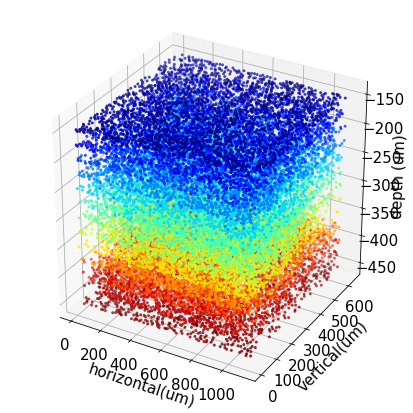

In [5]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

In [6]:
print(np.min(x),np.max(x))
print(np.min(y),np.max(y))
print(np.min(z),np.max(z))


6.0 1126.0
6.65 638.4000000000001
-450.0 -150.0


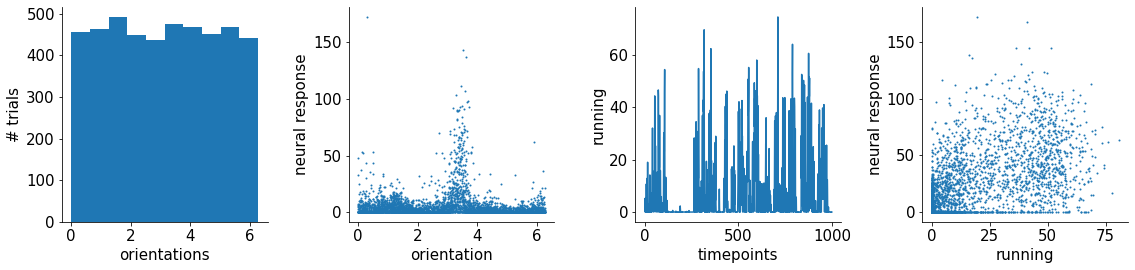

In [7]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

In [8]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
X = PCA(n_components = 200).fit_transform(Z.T)

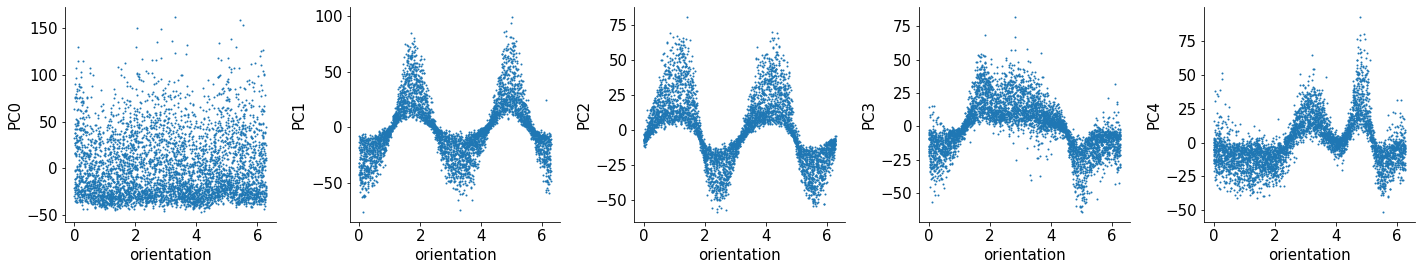

In [9]:
#@title plot PCs as function of stimulus orientation
for j in range(5):
  ax = plt.subplot(1,5,j+1)
  plt.scatter(dat['istim'], X[:,j], s = 1)
  ax.set(xlabel='orientation', ylabel = 'PC%d'%j)
plt.show()

In [10]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
!pip install umap-learn
from umap import UMAP
ncomp = 3 # try 2, then try 3
xinit = 3 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 1.1MB 9.1MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=568de191faa6875da61de3fcdc72b60776d2871cc092d14eeca0293a1db8b166
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.4-cp37-none-any.whl size=52374 sha256=d2cd3bddb890269e8efc12b181e906507c2a46bef70be5ea046760b1a9deea2d
  Stored in directory: /root/.cache/pip/wheels/42/4b/8c/f6f119c67cf6583bb192431fa8f7278cf95e5b943055077d94
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


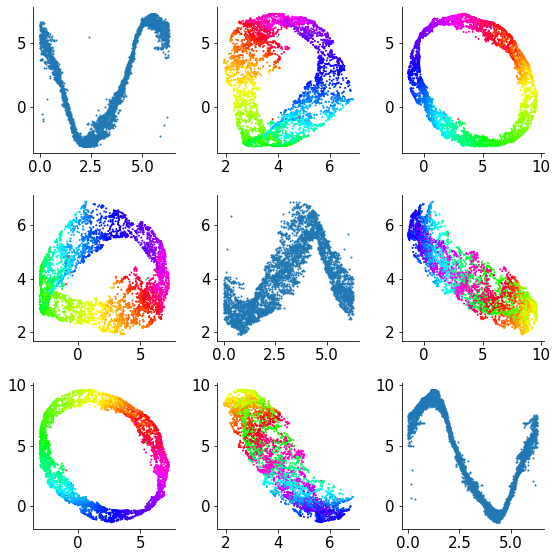

In [11]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i==j:
      plt.scatter(dat['istim'], embed[:,i], s  = 1)
    else:
      plt.scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')
# Is that a Mobius strip? A good project would be to try to figure out why (I don't know). 

In [12]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import scipy.cluster.hierarchy as sch


In [13]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [14]:
# setting distance_threshold=0 ensures we compute the full tree.
#model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

#model = model.fit(dat['sresp'])


In [15]:
#labels = model.labels_

NameError: ignored

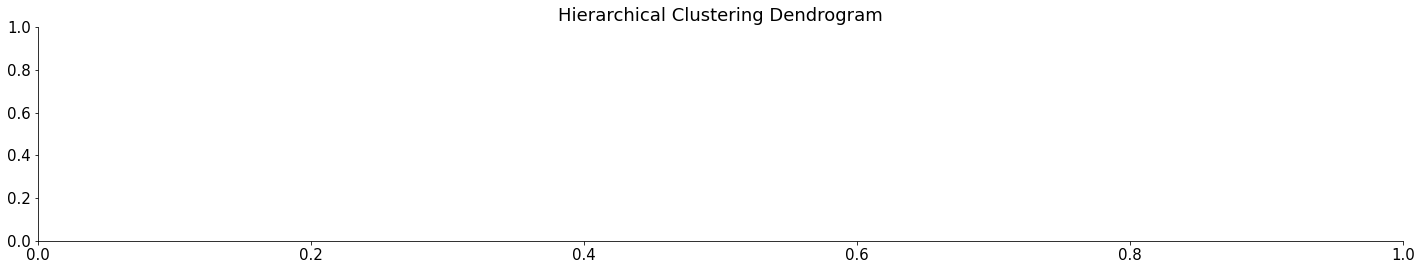

In [16]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
X=dat['sresp']
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(X[labels==3, 0], X[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(X[labels==4, 0], X[labels==4, 1], s=50, marker='o', color='orange')
plt.show()

# New Section

In [217]:
x,y,z = dat['xyz']
print(np.unique(z))
layerindex=np.zeros((13),dtype=int)
for i in range(0,13):
  #k=np.where(z == -150-i*25)
  print(i,-150-i*25,z[z==-150-i*25].shape,np.where(z == -150-i*25),np.where(z == -150-i*25)[0][0])
  layerindex[i]=np.where(z == -150-i*25)[0][0]
  i=i+1
layerindex
print(layerindex)
for i in range(0,13):
    print(i,layerindex[i],layerindex[i+1]-1)

[-450. -425. -400. -375. -350. -325. -300. -275. -250. -225. -200. -175.
 -150.]
0 -150 (1815,) (array([   0,    1,    2, ..., 1812, 1813, 1814]),) 0
1 -175 (1760,) (array([1815, 1816, 1817, ..., 3572, 3573, 3574]),) 1815
2 -200 (1659,) (array([3575, 3576, 3577, ..., 5231, 5232, 5233]),) 3575
3 -225 (1682,) (array([5234, 5235, 5236, ..., 6913, 6914, 6915]),) 5234
4 -250 (1764,) (array([6916, 6917, 6918, ..., 8677, 8678, 8679]),) 6916
5 -275 (1811,) (array([ 8680,  8681,  8682, ..., 10488, 10489, 10490]),) 8680
6 -300 (1901,) (array([10491, 10492, 10493, ..., 12389, 12390, 12391]),) 10491
7 -325 (2011,) (array([12392, 12393, 12394, ..., 14400, 14401, 14402]),) 12392
8 -350 (2167,) (array([14403, 14404, 14405, ..., 16567, 16568, 16569]),) 14403
9 -375 (2280,) (array([16570, 16571, 16572, ..., 18847, 18848, 18849]),) 16570
10 -400 (1871,) (array([18850, 18851, 18852, ..., 20718, 20719, 20720]),) 18850
11 -425 (1573,) (array([20721, 20722, 20723, ..., 22291, 22292, 22293]),) 20721
12 -450 

IndexError: ignored

In [24]:
def calculate_orientation_selectivity( neuron_response, orientations ):
	#Arguments:
  #neuron_response: ndarray (1 x Number of stimuli) - Neuron response to each stimulus.
  #orientations: ndarray (1 x Number of stimuli) - orientation of grating in each stimuli (in radians).
	#Returns:
  #orientation_selectivity: float - the preferred orientation (in radians) this neuron.
	#Description:
  #This function takes an array of responses for a single neuron, and an array of orientations which those responses correspond to. 
  #It then calculates which orientation generates the largest response for this neuron, and returns that orientation as a scalar value.

  max_activity_index=np.argmax(neuron_response)
  orientation_selectivity=orientations[max_activity_index]

  return orientation_selectivity

def calculate_all_orientation_selectivities( neuron_responses, orientations ):
	#Arguments:
  #neuron_responses: ndarray (no. of neurons x Number of stimuli) - Neuron responses to each stimulus.
  #orientations: ndarray (1 x Number of stimuli) - orientation of grating in each stimuli (in radians).
	#Returns:
  #orientation_selectivities: array (1 x Number of neurons) - the preferred orientations (in radians) for each neuron.
	#Description:
  #This function just applies the previous function (calculate_orientation_selectivity) over an array of multiple neurons, 
  #returning the feature selectivity for each neuron.
  orientation_selectivities=np.array([0.00] * len(neuron_responses))

  for i in range(len(neuron_responses)):
      orientation_selectivities[i]=calculate_orientation_selectivity(dat['sresp'][i],dat['istim'])

  return orientation_selectivities



In [212]:
for i in range(0,13):
    orientation_selectivities=calculate_all_orientation_selectivities(dat['sresp'][layerindex[i]:layerindex[i+1]-1],dat['istim'])


(23589,)

In [85]:

def calculate_orientation_diff(orientation1,orientation2):
    diff=np.absolute(orientation1-orientation2)
    if(diff>np.pi): diff=diff-np.pi
    return diff
    
def quantify_pinwheel( neuron_positions, orientation_selectivities):
	#Arguments:
  #neuron_positions: ndarray (no. of neurons x 3) - The xyz position of each neuron
  #orientation_selectivites: ndarray (1 x Number of neurons) - orientation selectivity of each neuron (in radians).
	#Returns:
  #euclidean _distances: ndarray (Number of neurons X Number of neurons) of pairwise distances between neurons.
  #orientation_similarity: ndarray (Number of neurons X Number of neurons) of cosine similarity between pairwise combinations of neurons.
  #Description:
  #This function should compare the orientation selectivities for all neurons using cosine similarity and calculate the euclidean distance between them, returning each as a vector.

  x,y,z=neuron_positions
  n=len(neuron_positions[0])
  euclidean_distances=np.zeros((n,n),dtype=float)
  orientation_similarity=np.zeros((n,n),dtype=float)
  
  for i in range(n):
    for j in range(n) :
      euclidean_distances[i][j]=np.sqrt((x[i]-x[j])**2+ (y[i]-y[j])**2 +(z[i]-z[j])**2)
      orientation_similarity[i][j]=calculate_orientation_diff(orientation_selectivities[i],orientation_selectivities[j])
  return euclidean_distances,orientation_similarity


euclidean_distances,orientation_similarity=quantify_pinwheel(dat['xyz'][:,0:3],orientation_selectivities)
print(euclidean_distances)
print(orientation_similarity)
print(euclidean_distances.flatten())
#lowerTri=np.tril(euclidean_distances, -1).T.ravel()
#print(lowerTri[lowerTri!=0])

[[  0.         638.82048339 203.94139575]
 [638.82048339   0.         742.44600942]
 [203.94139575 742.44600942   0.        ]]
[[0.         2.18665054 0.23876616]
 [2.18665054 0.         1.19370827]
 [0.23876616 1.19370827 0.        ]]
[  0.         638.82048339 203.94139575 638.82048339   0.
 742.44600942 203.94139575 742.44600942   0.        ]


In [123]:
def calculate_orientation_diff(orientation1,orientation2):
    diff=np.absolute(orientation1-orientation2)
    if(diff>np.pi): diff=diff-np.pi
    return diff
    
def quantify_pinwheel( neuron_positions, orientation_selectivities):
	#Arguments:
  #neuron_positions: ndarray (no. of neurons x 3) - The xyz position of each neuron
  #orientation_selectivites: ndarray (1 x Number of neurons) - orientation selectivity of each neuron (in radians).
	#Returns:
  #euclidean _distances: ndarray (Number of neurons X Number of neurons) of pairwise distances between neurons.
  #orientation_similarity: ndarray (Number of neurons X Number of neurons) of cosine similarity between pairwise combinations of neurons.
  #Description:
  #This function should compare the orientation selectivities for all neurons using cosine similarity and calculate the euclidean distance between them, returning each as a vector.

  x,y,z=neuron_positions
  n=len(neuron_positions[0])
  lower_triangle_size=int ((n*(n-1))/2)
  euclidean_distances=np.zeros((lower_triangle_size),dtype=float)
  orientation_similarity=np.zeros((lower_triangle_size),dtype=float)
  k=0
  for i in range(n):
    for j in range(i) :
      euclidean_distances[k]=np.sqrt((x[i]-x[j])**2+ (y[i]-y[j])**2 +(z[i]-z[j])**2)
      orientation_similarity[k]=calculate_orientation_diff(orientation_selectivities[i],orientation_selectivities[j])
      k=k+1
  return euclidean_distances,orientation_similarity


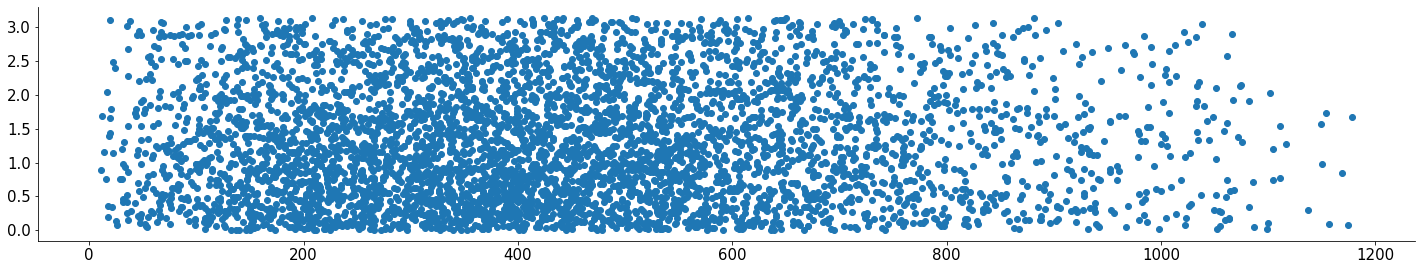

In [165]:
euclidean_distances,orientation_similarity=quantify_pinwheel(dat['xyz'][:,0:100],orientation_selectivities)
plt.scatter(euclidean_distances,orientation_similarity)

In [191]:
x,y,z = dat['xyz']
print(dat['xyz'][:,3575])


[ 544.    143.64 -200.  ]


No handles with labels found to put in legend.


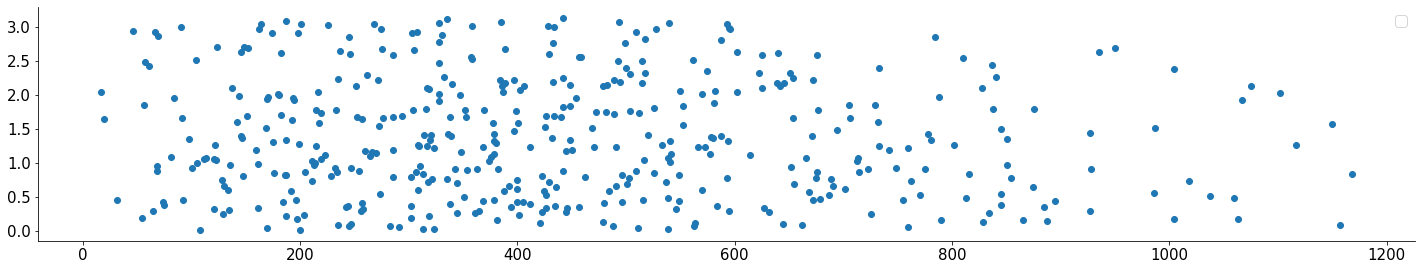

No handles with labels found to put in legend.


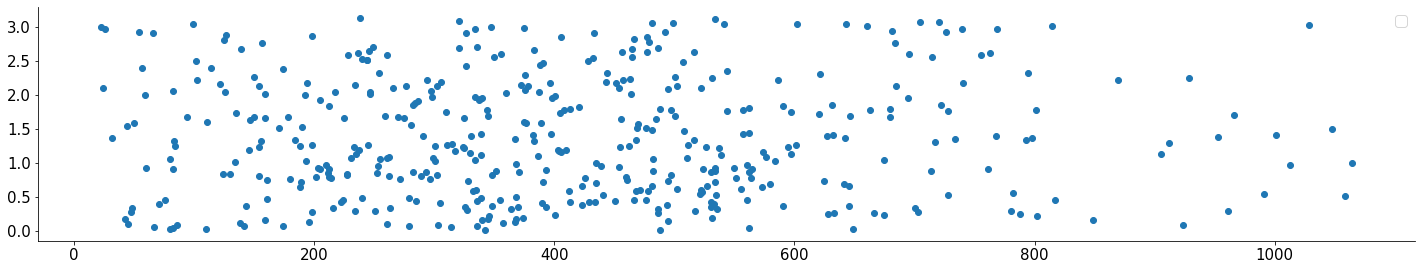

No handles with labels found to put in legend.


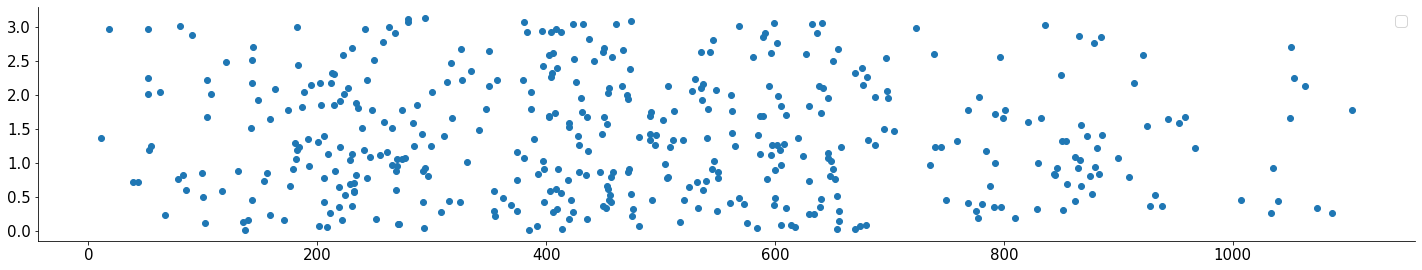

No handles with labels found to put in legend.


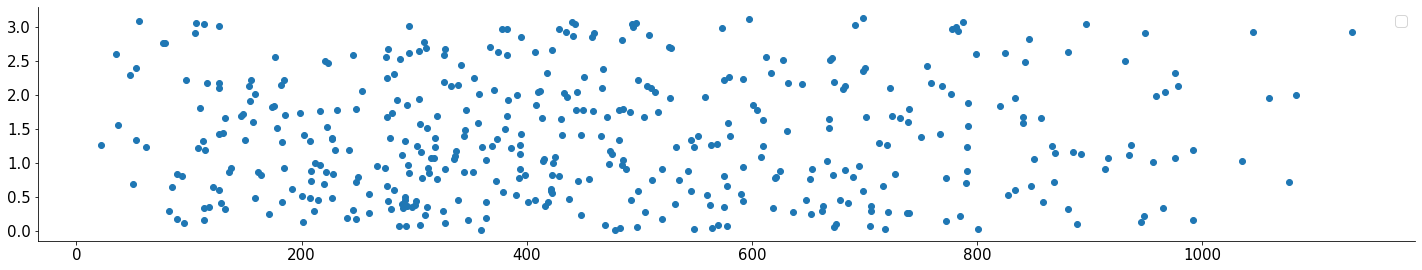

No handles with labels found to put in legend.


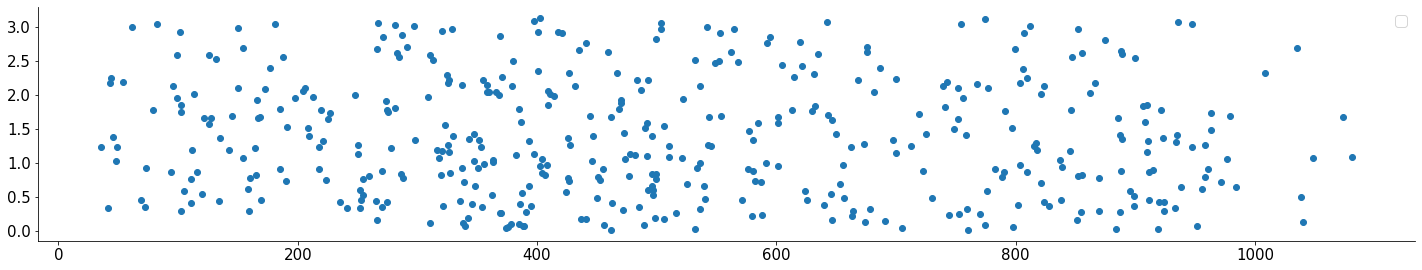

No handles with labels found to put in legend.


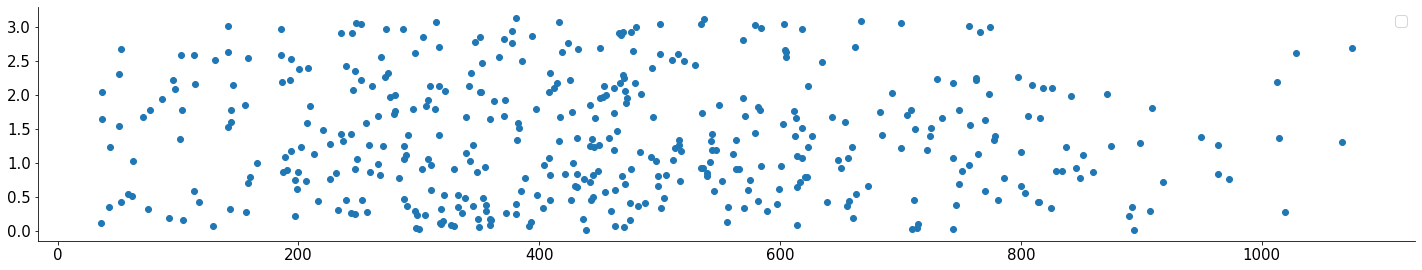

No handles with labels found to put in legend.


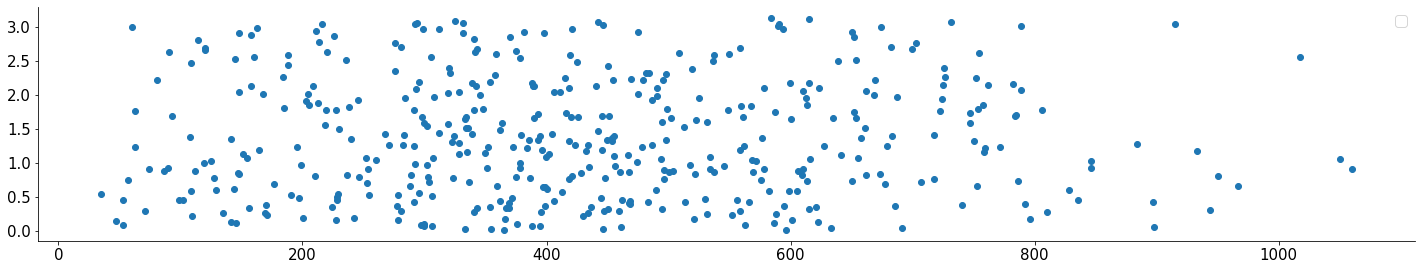

No handles with labels found to put in legend.


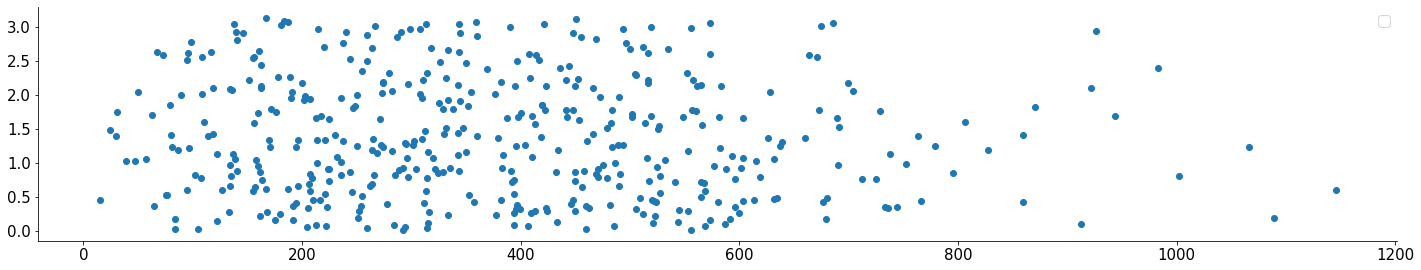

No handles with labels found to put in legend.


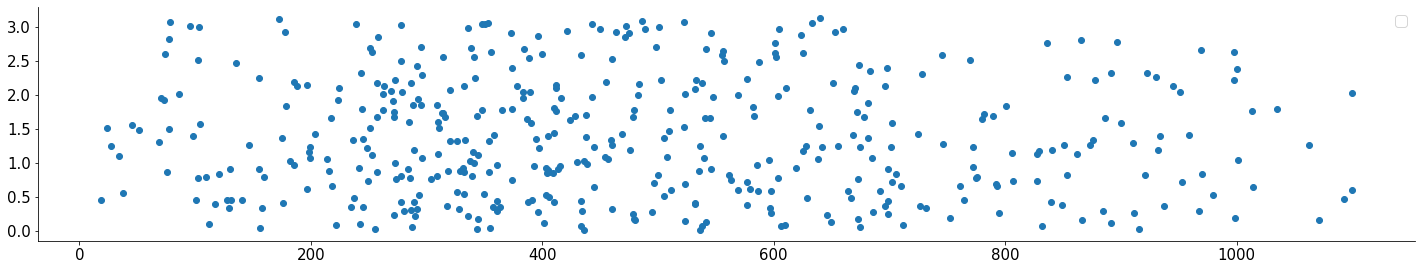

No handles with labels found to put in legend.


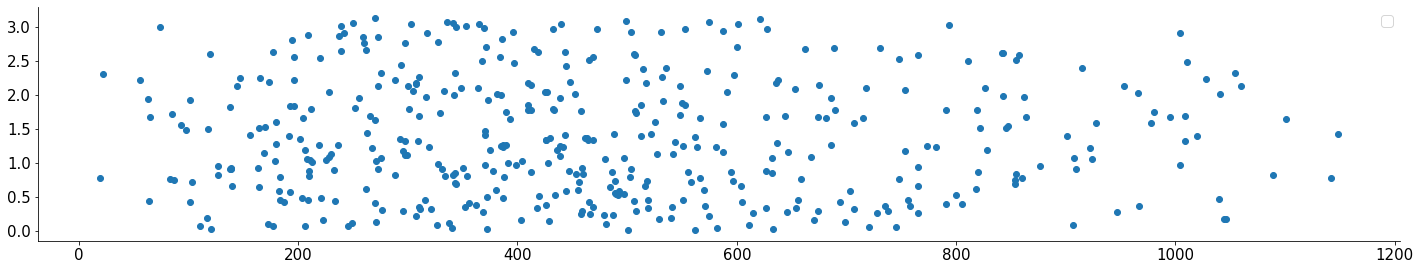

In [146]:
for i in range(0,10):
   euclidean_distances,orientation_similarity=quantify_pinwheel(dat['xyz'][:,30*i:30*i+30],orientation_selectivities)
   plt.scatter(euclidean_distances,orientation_similarity)
   plt.legend()
   plt.show()

No handles with labels found to put in legend.


[ 638.82048339  203.94139575  742.44600942  701.82872733 1149.44752925
  498.99563164  577.49847108  122.46057366  654.04868351 1037.31173791]
[2.18665054 0.23876616 1.19370827 0.61381762 1.57283292 2.76654119
 1.13223959 1.05441096 2.24811922 0.51842197]


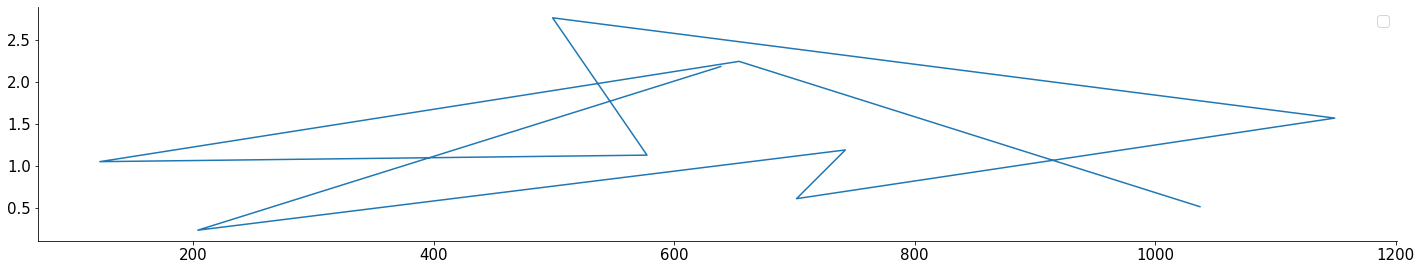

In [168]:

euclidean_distances,orientation_similarity=quantify_pinwheel(dat['xyz'][:,0:5],orientation_selectivities)
print(euclidean_distances)
#euclidean_distances=euclidean_distances/(np.linalg.norm(euclidean_distances) + 1e-16)
#print(euclidean_distances)
print(orientation_similarity)
#orientation_similarity=orientation_similarity/(np.linalg.norm(orientation_similarity) + 1e-16)
#print(orientation_similarity)
plt.plot(euclidean_distances,orientation_similarity)


#plt.plot(x,orientation_similarity,label = "orientation_similarity")
# # naming the x axis
# plt.xlabel('neuron')
# # naming the y axis
# plt.ylabel('Avg orientation')
# # giving a title to my graph
# plt.title('Orientation Selectivity Average for a neuronal cluster vs neuron')
# # show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

In [ ]:
plt.scatter(euclidean_distances,orientation_similarity)

<BarContainer object of 190 artists>

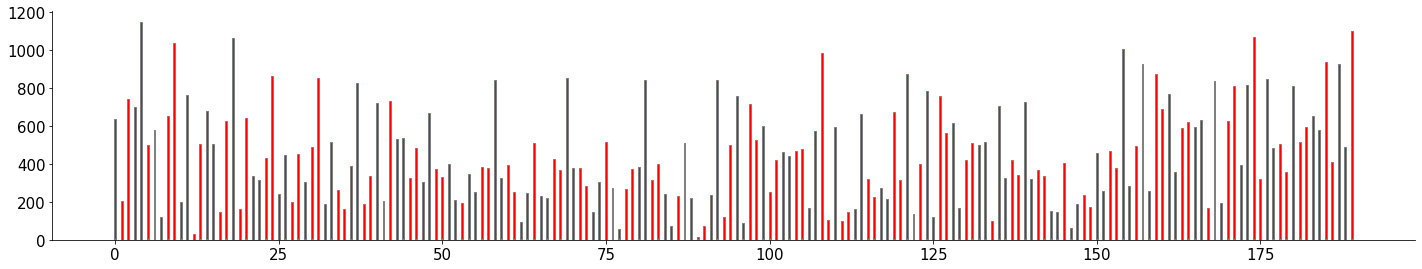

In [137]:
# Make the plot
x=np.array(range(0,len(euclidean_distances)))
plt.bar(x,euclidean_distances, color ='r', width = 0.3,
        edgecolor ='grey', label ='euclidean_distances')
plt.bar(x, orientation_similarity, color ='g', width = 0.3,
        edgecolor ='grey', label ='orientation_similarity')